In [218]:
import numpy as np 
import pandas as pd 
from tqdm import tqdm
from math import sqrt
import numbers

#plots
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

# for vectorization 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from gensim.models import Word2Vec

# similarity/distance measures
from scipy.spatial import distance
from sklearn.metrics.pairwise import linear_kernel

# sklearn
from sklearn.svm import LinearSVC
from sklearn.exceptions import DataConversionWarning; import warnings
from sklearn.linear_model import Lasso, LinearRegression, Ridge, ElasticNet, LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.datasets import make_classification
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import GridSearchCV

In [2]:
# load data
data = pd.read_csv('no_words.csv') # common words
data = data[data['title'].notna()]
#data = data.reset_index()

In [3]:
# create a column with article categories
data['x_cat'] = data['url'].str.replace('https://ekstrabladet.dk/nyheder/','')
data['x_cat'] = data['x_cat'].str.replace('https://ekstrabladet.dk/','')
data['x_cat'] = data['x_cat'].apply(lambda x: x.split('/')[0])
data = data[~data.x_cat.str.contains('-')]

In [4]:
# remove articles without category
for i, cat in enumerate(data['x_cat']):
    if '-' in cat:
        data['x_cat'][i].drop

In [5]:
# add column with the title lenght
len_title = []
for i in data['title']:
    len_title.append(len(i))
data['len_title'] = pd.DataFrame(data=len_title)

In [6]:
# drop nan
data = data[data['len_title'].notna()]

In [7]:
# blank column
data['set'] = 'hi'

# split the data in 2 
n = len(data['set'])
if n%2 !=0:
    n -= 1
n1 = int(n/2)

In [8]:
# save as traning and test
# data['set'][:n1] = 'test'
# data['set'][n1:n] = 'train'
# df_train = data[data.set=="train"]
# df_test = data[data.set=="test"]

# splitting into train and test set
X_train_rm, X_test_rm, y_train_rm, y_test_rm = train_test_split(data['proc_title_rm'], data['comments'], test_size=1/2, random_state=1)
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(data['x_cat'], data['comments'], test_size=1/2, random_state=1)
X_train_len, X_test_len, y_train_len, y_test_len = train_test_split(data['len_title'], data['comments'], test_size=1/2, random_state=1)

# models

### OLS

In [9]:
# pipeline for the processed titles and categories
pipeline_ols = Pipeline([
    ('vect', CountVectorizer()),
    ('pol', PolynomialFeatures(include_bias=True)),
    ('clf', LinearRegression()),
])

# param grid for the processed titles and categories
param_grid_ols = {"vect__ngram_range": [(1,1), (1,2), (1,3), (1,4)],
            'pol__degree': [1,2,3]
             }

# pipeline for the title lenghts
pipeline_ols_len = Pipeline([
    ('pol', PolynomialFeatures(include_bias=True)),
    ('clf', LinearRegression()),
])

# param grid for the title lenghts
param_grid_ols_len = {'pol__degree': [1,2,3]}


# for storing the results
search_ols_rm = GridSearchCV(pipeline_ols, param_grid_ols, scoring='neg_mean_squared_error', cv=3, verbose=10, n_jobs = 4, return_train_score=True)
search_ols_cat = GridSearchCV(pipeline_ols, param_grid_ols, scoring='neg_mean_squared_error', cv=3, verbose=10, n_jobs = 4, return_train_score=True)
search_ols_len = GridSearchCV(pipeline_ols_len, param_grid_ols_len, scoring='neg_mean_squared_error', cv=3, verbose=10, n_jobs = 4, return_train_score=True)
ols_result = []

In [10]:
# run each data set in the model and store results
search_ols_rm.fit(X_train_rm, y_train_rm)
ols_result.append(search_ols_rm)
search_ols_cat.fit(X_train_cat, y_train_cat)
ols_result.append(search_ols_cat)
search_ols_len.fit(X_train_len.values.reshape(-1,1), y_train_len)
ols_result.append(search_ols_len)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done  33 out of  36 | elapsed:  2.8min remaining:   15.1s
[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:  3.4min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Batch computation too fast (0.0590s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s


Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=4)]: Batch computation too fast (0.1846s.) Setting batch_size=4.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.2s


Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=4)]: Done  25 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  33 out of  36 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Batch computation too fast (0.0136s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done   3 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   6 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   7 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   9 out of   9 | elapsed:    0.0s finished


In [40]:
# print the best params and mse
ols_models = ['search_ols_rm', 'search_ols_cat', 'search_ols_len']
rmse_ols = []
for i, name in enumerate(ols_models):
    mse = -ols_result[i].best_score_
    rmse_ols.append(sqrt(mse))
    print(f'{name} Best parameter set: {ols_result[i].best_params_}')
    print(f'{name} Best mse: {ols_result[i].best_score_}')

search_ols_rm Best parameter set: {'pol__degree': 1, 'vect__ngram_range': (1, 1)}
search_ols_rm Best mse: -41190.382464692724
search_ols_cat Best parameter set: {'pol__degree': 2, 'vect__ngram_range': (1, 1)}
search_ols_cat Best mse: -31231.535609233364
search_ols_len Best parameter set: {'pol__degree': 2}
search_ols_len Best mse: -39492.89130276841


### Lasso

In [12]:
# param list
lambdas = np.logspace(-4, 4, 10)

# pipeline for the processed titles and categories
pipeline_las = Pipeline([
    ('vect', CountVectorizer()),
    ('pol', PolynomialFeatures(include_bias=True)),
    ('las', Lasso(random_state=1))
])

# param grid used for all 3 data sets
param_grid_las = {'pol__degree': [1,2,3],
    'las__alpha': lambdas}

# pipeline for the title lenghts
pipeline_las_len = Pipeline([
    ('pol', PolynomialFeatures(include_bias=True)),
    ('las', Lasso(random_state=1))
])

# for storing the results
search_las_rm = GridSearchCV(pipeline_las, param_grid_las, scoring='neg_mean_squared_error', cv=3, verbose=10, n_jobs = 4, return_train_score=True)
search_las_cat = GridSearchCV(pipeline_las, param_grid_las, scoring='neg_mean_squared_error', cv=3, verbose=10, n_jobs = 4, return_train_score=True)
search_las_len = GridSearchCV(pipeline_las_len, param_grid_las, scoring='neg_mean_squared_error', cv=3, verbose=10, n_jobs = 4, return_train_score=True)
las_result = []

In [13]:
# run and save results from all the datasets
search_las_rm.fit(X_train_rm, y_train_rm)
las_result.append(search_las_rm)
search_las_cat.fit(X_train_cat, y_train_cat)
las_result.append(search_las_cat)
search_las_len.fit(X_train_len.values.reshape(-1,1), y_train_len)
las_result.append(search_las_len)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Batch computation too fast (0.1640s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Batch computation too slow (6.8018s.) Setting batch_size=1.
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:   32.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   53.5s
[Parallel(n_jobs=4)]: Done  31 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done  40 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  49 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done  60 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done  72 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:  1.8min finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1905s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0887s.) Setting batch_size=4.
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1992s.) Setting batch_size=8.
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:    2.1s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Batch computation too fast (0.0147s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0284s.) Setting batch_size=4.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0341s.) Setting batch_size=8.
[Parallel(n_jobs=4)]: Done  73 out of  90 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:    0.1s finished


In [42]:
# print best params and mse
las_models = ['search_las_rm', 'search_las_cat', 'search_las_len']
rmse_las = []
for i, name in enumerate(las_models):
    mse = -las_result[i].best_score_
    rmse_las.append(sqrt(mse))
    print(f'{name} Best parameter set: {las_result[i].best_params_}')
    print(f'{name} Best mse: {las_result[i].best_score_}')

search_las_rm Best parameter set: {'las__alpha': 0.3593813663804626, 'pol__degree': 3}
search_las_rm Best mse: -38762.14631672766
search_las_cat Best parameter set: {'las__alpha': 0.005994842503189409, 'pol__degree': 3}
search_las_cat Best mse: -31213.31834224283
search_las_len Best parameter set: {'las__alpha': 166.81005372000558, 'pol__degree': 1}
search_las_len Best mse: -39437.31709794992


### Elastic

In [15]:
ela__l1_ratio = np.linspace(-1, 1, 10)

# with vect
pipeline_ela = Pipeline([
    ('vect', CountVectorizer()),
    ('pol', PolynomialFeatures(include_bias=True)),
    ('ela', ElasticNet())
])

param_grid_ela = {'pol__degree': [1,2,3],
                 'ela__l1_ratio': ela__l1_ratio}

# no vect for numbers
pipeline_ela_cat = Pipeline([
    ('pol', PolynomialFeatures(include_bias=True)),
    ('ela', ElasticNet())
])

search_ela_rm = GridSearchCV(pipeline_ela, param_grid_ela, scoring='neg_mean_squared_error', cv=3, verbose=10, n_jobs = 4, return_train_score=True)
search_ela_cat = GridSearchCV(pipeline_ela, param_grid_ela, scoring='neg_mean_squared_error', cv=3, verbose=10, n_jobs = 4, return_train_score=True)
search_ela_len = GridSearchCV(pipeline_ela_cat, param_grid_ela, scoring='neg_mean_squared_error', cv=3, verbose=10, n_jobs = 4, return_train_score=True)

ela_result = []

In [16]:
# run and save results from all the datasets
search_ela_rm.fit(X_train_rm, y_train_rm)
ela_result.append(search_ela_rm)
search_ela_cat.fit(X_train_cat, y_train_cat)
ela_result.append(search_ela_cat)
search_ela_len.fit(X_train_len.values.reshape(-1,1), y_train_len)
ela_result.append(search_ela_len)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    9.8s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   25.7s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  4.1min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  4.5min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  5.0min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  5.2min
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:  5.3min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1919s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1434s.) Setting batch_size=4.
[Parallel(n_jobs=4)]: Done  83 out of  90 | elapsed:    4.1s remaining:    0.3s
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Batch computation too fast (0.0155s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done   5 tasks     

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:    0.1s finished
C:\Users\Jonat\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 219200088.2881481, tolerance: 10964.384457142856
  positive)


In [43]:
# print best params and mse
ela_models = ['search_ela_rm', 'search_ela_cat', 'search_ela_len']
rmse_ela = []
for i, name in enumerate(ela_models):
    mse = -ela_result[i].best_score_
    rmse_ela.append(sqrt(mse))
    print(f'{name} Best parameter set: {ela_result[i].best_params_}')
    print(f'{name} Best mse: {ela_result[i].best_score_}')

search_ela_rm Best parameter set: {'ela__l1_ratio': 1.0, 'pol__degree': 2}
search_ela_rm Best mse: -39276.97467045986
search_ela_cat Best parameter set: {'ela__l1_ratio': 1.0, 'pol__degree': 1}
search_ela_cat Best mse: -31679.9432522772
search_ela_len Best parameter set: {'ela__l1_ratio': -1.0, 'pol__degree': 2}
search_ela_len Best mse: -39493.45302127383


## Validation curves

In [104]:
# combine all the results for plotting together
list_results = []
for i in range(3):
    list_results.append(ols_result[i])
    list_results.append(las_result[i])
    list_results.append(ela_result[i])

In [175]:
ols_result[0].best_params_

{'pol__degree': 1, 'vect__ngram_range': (1, 1)}

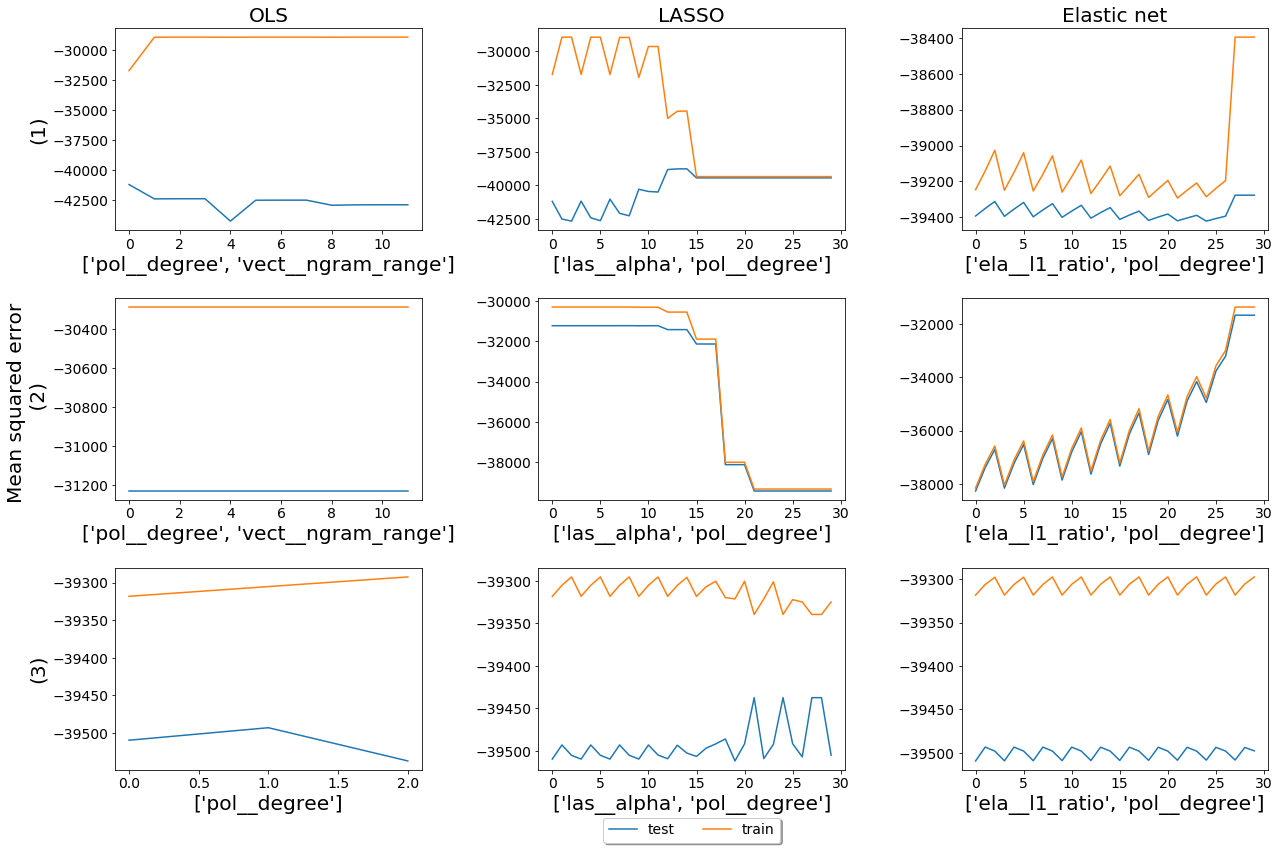

In [217]:
plt.rcParams.update({'font.size': 14})
fig, axs = plt.subplots(3, 3, figsize=(18,12))
count_total_it = 0
for i in range(3):
    for j in range(3):
        test_scores = list_results[count_total_it].cv_results_['mean_test_score']
        train_scores = list_results[count_total_it].cv_results_['mean_train_score'] 
        axs[i,j].plot(test_scores, label='test')
        axs[i,j].plot(train_scores, label='train')
        # creating the x-axis titles with params.
        optimal_params = []
        for param in list_results[count_total_it].best_params_:
            optimal_params.append(param)
            axs[i,j].set_xlabel(optimal_params, fontsize='x-large')
        count_total_it += 1
        #f.show()
# legends and titles
axs[0,0].set_title('OLS',fontsize='x-large')
axs[0,1].set_title('LASSO',fontsize='x-large')
axs[0,2].set_title('Elastic net',fontsize='x-large')
axs[0,0].set_ylabel('(1)', fontsize='x-large')
axs[1,0].set_ylabel('Mean squared error \n (2)', fontsize='x-large')
axs[2,0].set_ylabel('(3)', fontsize='x-large')
axs[2,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=5)
#axs[2,1].set_xlabel('Parameters', fontsize='x-large')
#fig.subplots_adjust(left=0.2, bottom=0.5, right=None, top=0.7, wspace=None, hspace=None)
fig.tight_layout()
plt.savefig(f"val_curves.pdf")

## Cross-validation

In [53]:
# rmse of the optimal mses
print(f'ols = {rmse_ols}')
print(f'las = {rmse_las}')
print(f'ela = {rmse_ela}')

ols = [202.95413882129313, 176.7244623962211, 198.72818447006557]
las = [196.88104610837394, 176.67291343678812, 198.58831057730944]
ela = [198.1841937957209, 177.98860427644576, 198.72959774848292]


### Ols

In [225]:
# feature 1
# optimal parameters for ols: {'pol__degree': 1, 'vect__ngram_range': (1, 1)}
# model with optimal param
pipeline_ols_rm_opt = Pipeline([
    ('vect', CountVectorizer(ngram_range = (1,1))),
    ('pol', PolynomialFeatures(include_bias=True, degree = 1)),
    ('clf', LinearRegression()),
])

# feature 2
# opt {'pol__degree': 2, 'vect__ngram_range': (1, 1)}
pipeline_ols_cat_opt = Pipeline([
    ('vect', CountVectorizer(ngram_range = (1,1))),
    ('pol', PolynomialFeatures(include_bias=True, degree = 2)),
    ('clf', LinearRegression()),
])

# feature 3
# opt {'pol__degree': 2}
pipeline_ols_len_opt = Pipeline([
    ('pol', PolynomialFeatures(include_bias=True, degree = 2)),
    ('clf', LinearRegression()),
])


# scores on test data
scores_ols_rm = cross_val_score(pipeline_ols_rm_opt, X_test_rm, y_test_rm, cv=5)
scores_ols_cat = cross_val_score(pipeline_ols_cat_opt, X_test_cat, y_test_rm, cv=5)
scores_ols_len = cross_val_score(pipeline_ols_len_opt, X_test_len.values.reshape(-1,1), y_test_rm, cv=5)

In [226]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_ols_rm.mean(), scores_ols_rm.std() * 2))
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_ols_cat.mean(), scores_ols_cat.std() * 2))
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_ols_len.mean(), scores_ols_len.std() * 2))

Accuracy: -0.08 (+/- 0.39)
Accuracy: 0.17 (+/- 0.02)
Accuracy: -0.00 (+/- 0.01)


### Lasso

In [230]:

# feature 1
# optimal par {'las__alpha': 0.3593813663804626, 'pol__degree': 3}
pipeline_las_rm_opt = Pipeline([
    ('vect', CountVectorizer()),
    ('pol', PolynomialFeatures(include_bias=True, degree = 3)),
    ('las', Lasso(random_state=1, alpha = 0.3593813663804626))
])

# feature 2
# opt {'las__alpha': 0.005994842503189409, 'pol__degree': 3}
pipeline_las_cat_opt = Pipeline([
    ('vect', CountVectorizer()),
    ('pol', PolynomialFeatures(include_bias=True, degree = 3)),
    ('las', Lasso(random_state=1, alpha = 0.005994842503189409))
])

# feature 3
# opt {'las__alpha': 166.81005372000558, 'pol__degree': 1}
pipeline_las_len_opt = Pipeline([
    ('pol', PolynomialFeatures(include_bias=True, degree = 1)),
    ('las', Lasso(random_state=1, alpha = 166.81005372000558))
])

# scores on test data
scores_las_rm = cross_val_score(pipeline_las_rm_opt, X_test_rm, y_test_rm, cv=5)
scores_las_cat = cross_val_score(pipeline_las_cat_opt, X_test_cat, y_test_rm, cv=5)
scores_las_len = cross_val_score(pipeline_las_len_opt, X_test_len.values.reshape(-1,1), y_test_rm, cv=5)

In [232]:
print("Accuracy_rm: %0.2f (+/- %0.2f)" % (scores_las_rm.mean(), scores_las_rm.std() * 2))
print("Accuracy_cat: %0.2f (+/- %0.2f)" % (scores_las_cat.mean(), scores_las_cat.std() * 2))
print("Accuracy_len: %0.2f (+/- %0.2f)" % (scores_las_len.mean(), scores_las_len.std() * 2))

Accuracy_rm: 0.02 (+/- 0.17)
Accuracy_cat: 0.17 (+/- 0.02)
Accuracy_len: -0.00 (+/- 0.01)


### ElasticNet

In [234]:
# feature 1
# Optimal par {'ela__l1_ratio': 1.0, 'pol__degree': 2}
pipeline_ela_rm_opt = Pipeline([
    ('vect', CountVectorizer()),
    ('pol', PolynomialFeatures(include_bias=True, degree = 2)),
    ('ela', ElasticNet(l1_ratio = 1.0))
])

# feature 2
# Optimal par {'ela__l1_ratio': 1.0, 'pol__degree': 1}
pipeline_ela_cat_opt = Pipeline([
    ('vect', CountVectorizer()),
    ('pol', PolynomialFeatures(include_bias=True, degree = 1)),
    ('ela', ElasticNet(l1_ratio = 1.0))
])

# feature 3
# Optimal par {'ela__l1_ratio': -1.0, 'pol__degree': 2}
pipeline_ela_len_opt = Pipeline([
    ('pol', PolynomialFeatures(include_bias=True, degree = 2)),
    ('ela', ElasticNet(l1_ratio = -1.0))
])

# scores on test data
scores_ela_rm = cross_val_score(pipeline_ela_rm_opt, X_test_rm, y_test_rm, cv=5)
scores_ela_cat = cross_val_score(pipeline_ela_cat_opt, X_test_cat, y_test_rm, cv=5)
scores_ela_len = cross_val_score(pipeline_ela_len_opt, X_test_len.values.reshape(-1,1), y_test_rm, cv=5)

C:\Users\Jonat\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 179120838.2198292, tolerance: 8966.2557747869
  positive)
C:\Users\Jonat\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 156159057.39110473, tolerance: 7810.358376401976
  positive)
C:\Users\Jonat\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 176672677.6445202, tolerance: 8841.827884349777
  positive)
C:\Users\Jonat\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

In [235]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_ela_rm.mean(), scores_ela_rm.std() * 2))
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_ela_cat.mean(), scores_ela_cat.std() * 2))
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_ela_len.mean(), scores_ela_len.std() * 2))

Accuracy: 0.02 (+/- 0.08)
Accuracy: 0.17 (+/- 0.02)
Accuracy: -0.00 (+/- 0.01)


## Learning curves

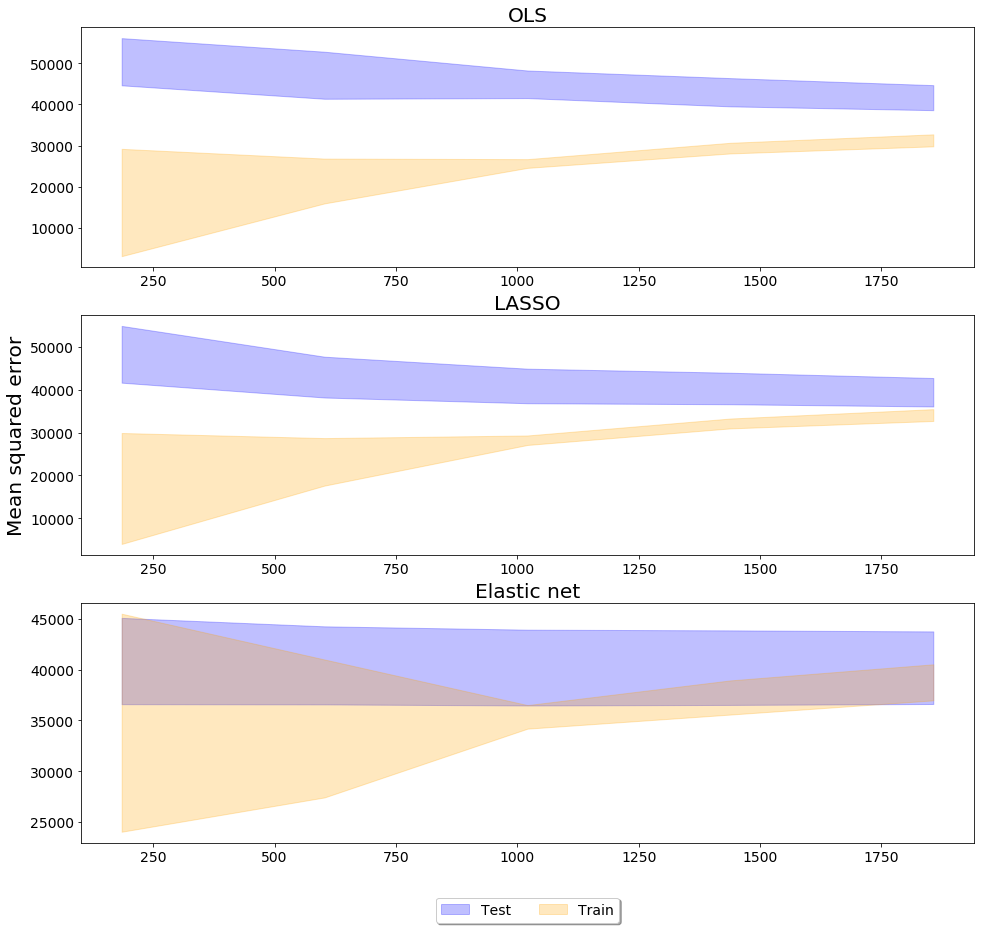

In [172]:
# fig with 3 subplots stacked
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(3, 1, figsize=(16,15))

# combine models for plotting
opt_models = [pipeline_ols_opt, pipeline_las_opt, pipeline_ela_opt]

# gen data
for i, model in enumerate(opt_models):
    train_sizes, train_scores, test_scores = learning_curve(estimator=model, X=X_train_rm, y=y_train_rm, cv=3, scoring='neg_mean_squared_error', n_jobs= 4)

    ax[i].fill_between(train_sizes,
                    -test_scores.min(1),
                    -test_scores.max(1), 
                    alpha=0.25, label ='Test', color='blue')

    ax[i].fill_between(train_sizes,
                    -train_scores.min(1),
                    -train_scores.max(1), 
                    alpha=0.25, label='Train', color='orange')
    #ax[i].set_yscale('log')
    
# titles and legends
ax[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=5)
ax[0].set_title('OLS', fontsize='x-large')
ax[1].set_title('LASSO', fontsize='x-large')
ax[2].set_title('Elastic net', fontsize='x-large')
#fig.suptitle('Range of performance (min, max)', fontsize='x-large')
ax[1].set_ylabel('Mean squared error', fontsize='x-large')
plt.savefig(f"learn_curves.pdf", bbox_inches='tight')